# Import libraries and install requirements

In [1]:
# !pip install nltk
# !pip install iso-639
# !pip install langdetect
# !pip install spaCy
# !pip install torch
# !pip install torchtext

In [2]:
# # The part before the install is for google colab formats
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# !pip install -U sentence_transformers

In [3]:
# # Installing all the languages for spacy lemmatizing
# # The part before the install is for google colab formats
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# !python -m spacy download en_core_web_sm
# !python -m spacy download pt_core_news_sm
# !python -m spacy download fr_core_news_sm
# !python -m spacy download da_core_news_sm
# !python -m spacy download de_core_news_sm
# !python -m spacy download es_core_news_sm
# !python -m spacy download sv_core_news_sm
# !python -m spacy download ca_core_news_sm
# !python -m spacy download zh_core_web_sm
# !python -m spacy download nb_core_news_sm
# !python -m spacy download nl_core_news_sm
# !python -m spacy download it_core_news_sm
# !python -m spacy download ru_core_news_sm
# !python -m spacy download pl_core_news_sm

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import chain

import nltk
import string
import re

from iso639 import languages

from wordcloud import WordCloud

from langdetect import detect_langs

import spacy

from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchtext.vocab as vocab

from sentence_transformers import SentenceTransformer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

c:\Users\Pedro\anaconda3\lib\site-packages\huggingface_hub\snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


# Functions

This section has all the functions we use in the remaining notebook. We define them all here so one can run only this and the final section to get the final model's predictions.

In [5]:
def join_datasets(df_des, df_rev):
    """This function gets a dataset with host and descriptions and one with reviews and merges them so we have all reviews for one airbnb in one single row"""

    # First we merge the datasets, getting repeated description and host about rows
    df_aux = df_des.merge(df_rev, how='left', on = 'index') # note we do a left join because there are descriptions without reviews

    # Then we want the repeated rows to disappear. We want to do that by having the comment column to be a list of comments, not a singular one
    df = df_aux.groupby('index').agg({'description': 'first', 'host_about': 'first','comments': list, 'unlisted': 'first'}).reset_index()

    # The rows with no columns will have a list with a nan, so we will transform that into an empty list
    df['comments'] = df['comments'].apply(lambda x: [] if x == [np.nan] else x)

    return df

def join_test_datasets(df_des, df_rev):
    """This function gets a test dataset with host and descriptions and one with reviews and merges them so we have all reviews for one airbnb in one single row"""

    # First we merge the datasets, getting repeated description and host about rows
    df_aux = df_des.merge(df_rev, how='left', on = 'index') # note we do a left join because there are descriptions without reviews

    # Then we want the repeated rows to disappear. We want to do that by having the comment column to be a list of comments, not a singular one
    df = df_aux.groupby('index').agg({'description': 'first', 'host_about': 'first','comments': list}).reset_index()

    # The rows with no columns will have a list with a nan, so we will transform that into an empty list
    df['comments'] = df['comments'].apply(lambda x: [] if x == [np.nan] else x)

    return df

def detect_language(texts):
    """This function gets a list of texts and does the language detection
    for them, returning a list with the same length and the languages in the order of the input list"""
    languages = []

    for text in texts:
        try:
            detected_langs = detect_langs(text)
            languages.append(detected_langs[0].lang)

        except:
            languages.append('en')

    return languages

# We needed to make some alterations to the detection because we need the output to have a list for every row
# in the case of the reviews, so we created this function
def detect_reviews_language(comments_lists):
    """Gets a list of lists of text and return the languages in the same format and order"""
    lang = []

    # We needed to add a layer because we have lists of test inside a series of lists of texts
    for comments in tqdm(comments_lists):
        lang.append(detect_language(comments))

    return lang

# Loading the models for all langages we'll use
nlp_en = spacy.load("en_core_web_sm")
nlp_pt = spacy.load("pt_core_news_sm")
nlp_fr = spacy.load("fr_core_news_sm")
nlp_da = spacy.load("da_core_news_sm")
nlp_de = spacy.load("de_core_news_sm")
nlp_es = spacy.load("es_core_news_sm")
nlp_sv = spacy.load("sv_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")
nlp_zh = spacy.load("zh_core_web_sm")
nlp_no = spacy.load("nb_core_news_sm")
nlp_nl = spacy.load("nl_core_news_sm")
nlp_it = spacy.load("it_core_news_sm")
nlp_ru = spacy.load("ru_core_news_sm")
nlp_pl = spacy.load("pl_core_news_sm")

# This will perform lemmatization according to the language
def lemmatize_text(text, language):
    """ This function gets text and its language and lemmatizes it accordingly.
    If given a language that is not in the 14 languages it supports, it reverts to english"""
    if language == "en":
        doc = nlp_en(text)
    elif language == "pt":
        doc = nlp_pt(text)
    elif language == "fr":
        doc = nlp_fr(text)
    elif language == "da":
        doc = nlp_da(text)
    elif language == "de":
        doc = nlp_de(text)
    elif language == "es":
        doc = nlp_es(text)
    elif language == "sv":
        doc = nlp_sv(text)
    elif language == "ca":
        doc = nlp_ca(text)
    elif language == "zh-cn":
        doc = nlp_zh(text)
    elif language == "no":
        doc = nlp_no(text)
    elif language == "nl":
        doc = nlp_nl(text)
    elif language == "it":
        doc = nlp_it(text)
    elif language == "ru":
        doc = nlp_ru(text)
    elif language == "pl":
        doc = nlp_pl(text)
    # If it is not any of those languages, use english
    else:
        doc = nlp_en(text)

    lemmas = " ".join([token.lemma_ for token in doc if token.is_alpha])
    return lemmas

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

def clean(text_list, language_list, lemmatize, stemmer, status = True):
    """Gets a list of text and lowercases, removes HTML tags, numerical data, ponctuation and emojis.
    It also will do lemmatization or stemming according to input."""

    updates = []

    # Define emojis
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F" # emoticons
                                u"\U0001F300-\U0001F5FF" # symbols & pictographs
                                u"\U0001F680-\U0001F6FF" # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)

    # This if is just to control wether we want to have the status bar
    if status:
        loop_range = tqdm(range(len(text_list)))
    else:
        loop_range = range(len(text_list))

    for j in loop_range:

        text = str(text_list[j])
        language = str(language_list[j])

        ## Cleaning that does not require language detection
        # Lowercase the text
        text = text.lower()

        # Remove HTML Tags, the <.*?> removes everything inside the tags, therefore removes html comments (br included)
        text = re.sub('<.*?>', "", text)

        # Remove everything numerical or ponctuation but keep word accents!
        text = re.sub("[^A-zÀ-ú]"," ", text )

        # Remove emojis
        text = emoji_pattern.sub(r'', text)

        # Processing that requires languages
        # Remove Stopwords
        try:
            # Transform language/country code into a language readable by nklt's stopwords
            j_lang=languages.get(alpha2 = language).name.lower()

            # Remove stopwords in that review's language
            text = ' '.join(word for word in text.split() if word not in set(stopwords.words(j_lang)))
        except:
            # If the language is not in nltk's stopwords, do it in english
            text = ' '.join(word for word in text.split() if word not in set(stopwords.words('english')))

        #Lemmatize
        if lemmatize:
            text = lemmatize_text(text=text,language=language)

        #Stemming
        if stemmer:
            # If the language exists in the reportoir
            try:
                j_lang=languages.get(alpha2 = language).name.lower()
                stemmer = SnowballStemmer(j_lang)
                text = " ".join(stemmer.stem(word) for word in text.split())
            except:
                # If the language does not exist in the stemmer, do it in english
                stemmer = SnowballStemmer('english')
                text = " ".join(stemmer.stem(word) for word in text.split())

        updates.append(text)

    return updates

def clean_dataframe(text_df):
    """Takes a text dataframe with description, host_about and comments columns
    and cleans it using the clean function defined earlier."""
    # Make a copy so we don't lose the initial dataframe
    df = text_df.copy()

    clean_description = clean(df['description'], df['description_lang'], lemmatize= True, stemmer = False)

    clean_host = clean(df['host_about'], df['host_lang'], lemmatize= True, stemmer = False)

    clean_rev = []
    for row in tqdm(range(len(df['comments']))):

        # List of lists of clean reviews
        clean_rev.append(clean(df['comments'][row], df['rev_lang'][row] , lemmatize= True, stemmer = False, status = False))

    df['description'] = clean_description
    df['host_about'] = clean_host
    df['comments'] = clean_rev

    return df

def remove_rarest(text_list, freq, status = True):
    """Removes the rarest words from the texts inside the text list according to the whole dataframe count freq.
    To be used only with the next function."""
    updates = []

    if status:
        loop_range = tqdm(range(len(text_list)))
    else:
        loop_range = range(len(text_list))

    for j in loop_range:
        text = str(text_list[j])

        # Remove rarest words from all corpus
        ### Remove a word if it appears only once in the corpus
        text = ' '.join(word for word in text.split() if freq[word] != 1)

        updates.append(text)

    return updates

def remove_rarest_from_df(text_df):
    """Takes a text dataframe and removes its text's rarest words."""
    # Make a copy so we don't lose the initial dataframe
    df = text_df.copy()

    # List with wordcounts to later usage in removing rare words
    all_words_desc = ' '.join(str(i) for i in df['description'])
    all_words_host = ' '.join(str(i) for i in df['host_about'])

    ### For reviews we need to flatten all reviews first to get all words
    reviews_list = df['comments'].values
    flattened_list = list(chain.from_iterable(reviews_list))
    all_words_rev = ' '.join(str(i) for i in flattened_list)

    ### Do a list with all words
    all_words_list = all_words_desc.split() + all_words_host.split() + all_words_rev.split()
    freq = pd.Series(all_words_list).value_counts()

    rare_description = remove_rarest(df['description'], freq)

    rare_host = remove_rarest(df['host_about'], freq)

    rare_rev = []
    for row in tqdm(range(len(df['comments']))):

        # List of lists of clean reviews
        rare_rev.append(remove_rarest(df['comments'][row], freq, status = False))

    df['description'] = rare_description
    df['host_about'] = rare_host
    df['comments'] = rare_rev

    return df

def divide_string(large_string, max_words=510):
    """Takes a string and divides it into strings with at most max_words"""
    # First split the large string into individual words
    words = large_string.split()

    divided = []
    aux = "" # this will help build each string

    for word in words:
        if len(aux.split()) + 1 > max_words:
            divided.append(aux.strip())
            aux = ""
        aux += word + " "

    if aux:
        divided.append(aux.strip())

    return divided

def train_tfidf_embed(df,columns):
  """ Train the tfidf model with given training data."""

  word_tfidf_train = TfidfVectorizer(max_df=0.8, ngram_range=(1, 1))

  dfs=df[columns[0]]
  for i in columns[1:]:
    dfs+= df[i] + ' '

  dfs = word_tfidf_train.fit_transform(dfs).toarray()

  return word_tfidf_train

def tfidf_embed(df,columns,word_tfidf ):
  """Using the previously trained tf-idf to embed the columns.
  It is separate to avoid data leakage"""

  dfs=df[columns[0]]
  for i in columns[1:]:
      dfs += df[i]+'  '
  X_word = word_tfidf.transform(dfs).toarray()

  final_df_embed = pd.DataFrame(X_word)
  final_df_embed.columns = [ 'column'+str(i) for i in range(len(final_df_embed.columns))]

  final_df_embed.index = df.index

  return final_df_embed

def get_word(word):
  """Returns the Glove vector"""
  try:
    return glove.vectors[glove.stoi[word]]
  except:
    return torch.zeros(50)

def get_vector(sentence):
  """ Given a sentence retunrs the average of the word embeddings"""
  if sentence=='':
    return torch.zeros(50)
  else:
    sentence = nltk.word_tokenize(sentence)
    my_list = list(map(lambda x: get_word(x),sentence))
    return torch.mean(torch.stack(my_list),axis=0)

def tensor_to_list(tensor):
  """Transforms tensor to array"""
  return tensor.numpy()

def glove_embed(df,columns):
  """Does the glove embedding all at once"""
  df_embed=pd.DataFrame()
  for column in columns:
    df_embed[column] = df[column].apply(get_vector).apply(tensor_to_list)

  dfs = [df_embed[column].apply(pd.Series) for column in columns]
  final_df_embed = pd.concat(dfs, axis=1)
  final_df_embed.columns = [ 'column'+str(i) for i in range(len(final_df_embed.columns))]

  final_df_embed.index = df.index

  return final_df_embed

def embed(column,model):
  """Gets a column and a word embedding model and transforms it into the
  embedded vector according to the model its using"""

  df=pd.DataFrame()
  df['data']=column
  df=df.explode('data')
  df=df.reset_index()
  df['data']=df['data'].astype(str)
  embedding=model.encode(df.data.values,show_progress_bar=True)
  df['data']=[i for i in embedding]
  df=pd.DataFrame(df.groupby('index').mean())

  return df['data'].values

def embed_df(df,columns,model):
  """Does the embedding of the full dataframe, returning an average of the columns individual embeddings."""
  df_embed=pd.DataFrame()
  for column in columns:
    df_embed[column] = embed(df[column], model)

  dfs = [df_embed[column].apply(pd.Series) for column in columns]
  final_df_embed = pd.concat(dfs, axis=1)

  # Do the mean to aggregate embeddings
  mean_df = final_df_embed.groupby(final_df_embed.columns, axis=1).mean()

  mean_df.columns = [ 'column'+str(i) for i in range(len(mean_df.columns))]
  mean_df.index = df.index

  return mean_df

def text_preprocessor(X):
    """Function to do all pre-embedding preprocessing"""
    df = X.copy()

    # Detect the languages in the dataset
    df['description_lang'] = detect_language(df['description'])
    df['host_lang'] = detect_language(df['host_about'])
    df['rev_lang'] = detect_reviews_language(df['comments'])

    df.reset_index(inplace=True)

    # General cleaning of the dataset and remove rarest words
    inter_df = clean_dataframe(df)
    clean_df = remove_rarest_from_df(inter_df)

    return clean_df

def feature_eng(clean_df, word_embedding_name):
    """Function to do feature engineering using word embeddings"""

    df = clean_df.copy()

    # Treat nans as empty strings
    df.fillna('', inplace=True)

    # # Account for empty lists filling them with empty strings
    # df['comments'] = df['comments'].apply(lambda x: x if len(x) > 0 else ' ')
    # df['host_about'] = df['host_about'].apply(lambda x: x if len(x) > 0 else ' ')
    # df['description'] = df['description'].apply(lambda x: x if (len(x) > 0) else ' ')

    # Make sure the columns are the right type and join the comments into a single string
    try:
      df['host_about'] = [str(df.host_about[i]) for i in range(len(df))]
      df['description'] = [str(df.description[i]) for i in range(len(df))]
      df['comments'] = [eval(df.comments[i]) for i in range(len(df))]
    except:
      pass
    df['comments_joined'] = [' '.join(line) for line in df['comments']]

    # Treat nans as empty strings again, because previously comments had lists and so would not detect nans with this, now it would
    df.fillna('', inplace=True)

    # Make sure the final values are strings
    for c in ['description', 'host_about', 'comments_joined']:
        df[c] = df[c].astype(str)

    # Set the index as index (if it isn't already) and get only the important columns
    try:
        df = df.set_index('index').loc[:,['description','host_about', 'comments_joined']]
    except:
        df = df.loc[:,['description','host_about', 'comments_joined']]

    df.rename(columns={'comments_joined':'comments'}, inplace=True)

    # Divide the strings into comportable lengths for the embedders
    df['description_div'] = tqdm(df.description.apply(divide_string))
    df['host_about_div'] = tqdm(df.host_about.apply(divide_string))
    df['comments_div'] = tqdm(df.comments.apply(divide_string))

    # Embeddings
    if word_embedding_name == "tf-idf":

        word_tfidf_trained  = train_tfidf_embed(df, ['description','host_about','comments'])

        return tfidf_embed(df, ['description','host_about','comments'], word_tfidf_trained)

    elif word_embedding_name == "glove":

        return glove_embed(df , ['description','host_about','comments'])

    elif word_embedding_name == "xlm":

        model_xlm = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')

        return embed_df(df, ['description_div','host_about_div','comments_div'], model_xlm)

    elif word_embedding_name == "distiluse":

        model_distiluse = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

        return embed_df(df, ['description_div','host_about_div','comments_div'], model_distiluse)

def modelling(model , x , y , train=False):
  """Function to help train and evaluate models"""
  if train == True:
    model.fit(x,y)
  y_pred = model.predict(x)
  print(classification_report(y , y_pred))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import the data

In [ ]:
# # For Google Colab data importation
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # In colab
# df_train_listings = pd.read_excel("/content/drive/MyDrive/Project/train.xlsx")
# df_train_reviews = pd.read_excel("/content/drive/MyDrive/Project/train_reviews.xlsx")

In [ ]:
# # In colab
# df_test_listings = pd.read_excel("/content/drive/MyDrive/Project/test.xlsx")
# df_test_reviews = pd.read_excel("/content/drive/MyDrive/Project/test_reviews.xlsx")

In [ ]:
df_train_listings = pd.read_excel("train.xlsx")
df_train_reviews = pd.read_excel("train_reviews.xlsx")

In [ ]:
df_test_listings = pd.read_excel("test.xlsx")
df_test_reviews = pd.read_excel("test_reviews.xlsx")

In [ ]:
df_train_reviews.head(3)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."


In [ ]:
df_train_listings.head(3)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1


We have a dataset with the listings and another with multiple reviews of the same listing. We will work with them separately until we reach the preprocessing stage.

The goal is to use the host and listing descriptions and the reviews to predict the label "unlisted", to see if the listing will or not be listed in the next quarter.

# 1. Data Exploration

## 1.1. Labeled Listings

In [ ]:
df_train_listings.shape

(12496, 4)

First of all, let's check if the dataset is balanced. We do this first, as basic statistics won't tell us much about the dataset, because we have binary labels.

In [ ]:
df_train_listings['unlisted'].value_counts()

0    9033
1    3463
Name: unlisted, dtype: int64

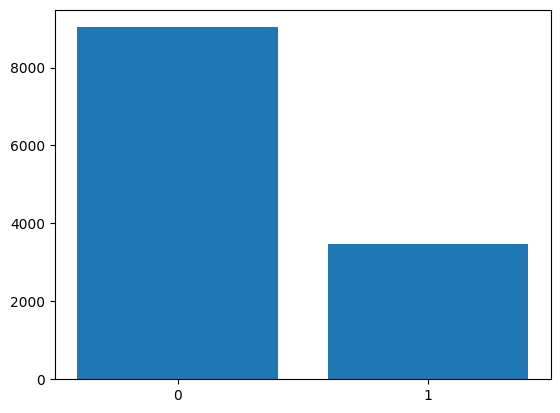

In [ ]:
counts = df_train_listings['unlisted'].value_counts()
x_values = [0, 1]
y_values = [counts[0], counts[1]]

plt.bar(x_values, y_values)
plt.xticks(x_values)  # Set the x-axis ticks to [0, 1]
plt.show()

The dataset is clearly unbalanced. There are less than half (close to a third) as many listings that were unlisted than the ones that mantained their presence in the website.

Let's check for null values on every feature of both our training datasets.

In [ ]:
df_train_listings.isna().sum()

index          0
description    0
host_about     0
unlisted       0
dtype: int64

No null values in the dataset.

### 1.1.1 Description

In [ ]:
df_train_listings['word_count_description'] = df_train_listings['description'].apply(lambda x: len(str(x).split(" ")))

df_train_listings.head(3)

,index,description,host_about,unlisted,word_count_description
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170


In [ ]:
df_train_listings.word_count_description.describe()

count    12496.000000
mean       132.663572
std         48.494104
min          3.000000
25%         99.000000
50%        157.000000
75%        167.000000
max        210.000000
Name: word_count_description, dtype: float64

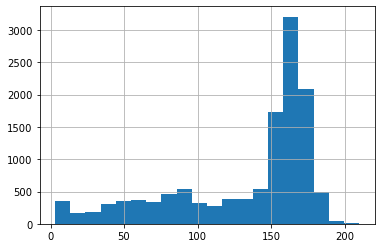

In [ ]:
df_train_listings['word_count_description'].hist(bins = 20)
plt.show()

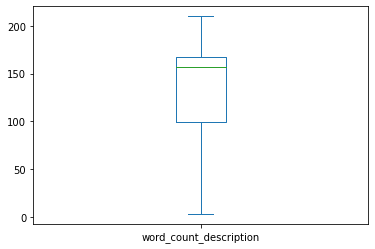

In [ ]:
df_train_listings['word_count_description'].plot.box()
plt.show()

In [ ]:
all_words_description = ' '.join(str(i) for i in df_train_listings['description'].values)

In [ ]:
all_words_description_list = all_words_description.split()

In [ ]:
freq_description = pd.Series(all_words_description_list).value_counts()
freq_description.sort_values(ascending=False)[0:10]

the      62717
and      54907
a        50700
/><br    34826
to       30520
of       30050
in       28007
with     27033
is       23957
de       13708
dtype: int64

In [ ]:
freq_description.sort_values(ascending=True)[0:400]

equip<br        1
bed/sofa        1
possibiliy      1
differents      1
chanel(2        1
               ..
Panasonic       1
two-bedrooms    1
"Trombeta       1
wor             1
GARDEN.         1
Length: 400, dtype: int64

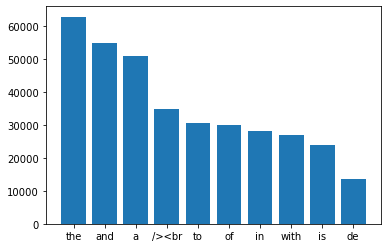

In [ ]:
plt.bar(freq_description.sort_values(ascending= False)[0:10].index, freq_description.sort_values(ascending=False)[0:10])
plt.show()

### 1.1.2 Host About

In [ ]:
df_train_listings['word_count_host_about'] = df_train_listings['host_about'].apply(lambda x: len(str(x).split(" ")))

df_train_listings.head(3)

,index,description,host_about,unlisted,word_count_description,word_count_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,127,4
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,23,24
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,170,45


In [ ]:
df_train_listings.word_count_host_about.describe()

count    12496.000000
mean        73.031050
std         77.132867
min          1.000000
25%         26.000000
50%         55.000000
75%        102.000000
max       1387.000000
Name: word_count_host_about, dtype: float64

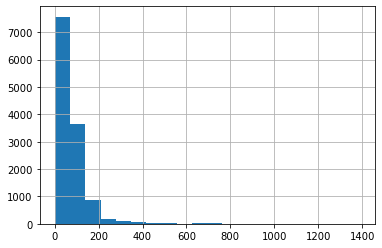

In [ ]:
df_train_listings['word_count_host_about'].hist(bins = 20)
plt.show()

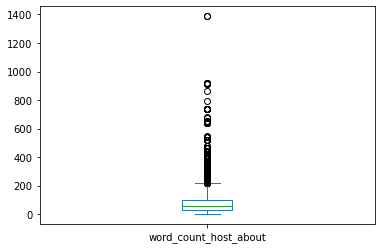

In [ ]:
df_train_listings['word_count_host_about'].plot.box()
plt.show()

In [ ]:
df_train_listings[df_train_listings['word_count_host_about'] > 512]

,index,description,host_about,unlisted,word_count_description,word_count_host_about
362,363,The holiday apartment Cascais Bay Terrace I is...,DE\nMit Bookiply finden Sie ganz einfach Ihre ...,1,117,738
443,444,Nice Villa for holidays in the center of Erice...,Tenho 63 anos e sou reformado por invalidez. S...,0,169,519
902,903,"The holiday apartment ""Casa da Jo - Beach Hous...",DE\nMit Bookiply finden Sie ganz einfach Ihre ...,1,169,738
1085,1086,"The vacation home ""Casa da Rocha"" is located i...",DE\nMit Bookiply finden Sie ganz einfach Ihre ...,1,162,738
1191,1192,Casa confortável com três quartos em que cada ...,Tenho 63 anos e sou reformado por invalidez. S...,1,167,519
...,...,...,...,...,...,...
11717,11718,House Mezzanine with pool <br />A totally rebu...,Tenho 63 anos e sou reformado por invalidez. S...,0,179,519
11913,11914,"House, on the first floor of a villa, fully eq...",Tenho 63 anos e sou reformado por invalidez. S...,0,75,519
12058,12059,"Luxury villa with a round pool, BBQ, private p...",Tenho 63 anos e sou reformado por invalidez. S...,0,73,519
12095,12096,"A camping zone prepared for families, single o...",GPS and exact location in our website look for...,1,57,542


In [ ]:
all_words_host_about = ' '.join(str(i) for i in df_train_listings['host_about'].values)

In [ ]:
all_words_host_about_list = all_words_host_about.split()

In [ ]:
freq_host_about = pd.Series(all_words_host_about_list).value_counts()
freq_host_about.sort_values(ascending=False)[0:10]

and    32569
to     26540
the    21488
a      21184
in     19515
I      12752
of     12752
you    12511
de      8739
We      8457
dtype: int64

In [ ]:
freq_description.sort_values(ascending=True)[0:400]

equip<br        1
bed/sofa        1
possibiliy      1
differents      1
chanel(2        1
               ..
Panasonic       1
two-bedrooms    1
"Trombeta       1
wor             1
GARDEN.         1
Length: 400, dtype: int64

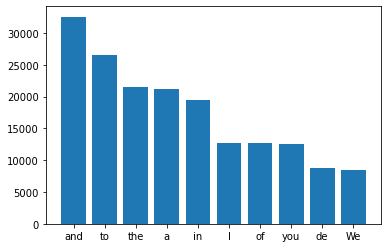

In [ ]:
plt.bar(freq_host_about.sort_values(ascending= False)[0:10].index, freq_host_about.sort_values(ascending=False)[0:10])
plt.show()

## 1.2. Reviews

In [ ]:
df_train_reviews.shape

(721402, 2)

In [ ]:
df_train_reviews.isna().sum()

index       0
comments    0
dtype: int64

Doing a word count for every review

In [ ]:
df_train_reviews['word_count'] = df_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))

df_train_reviews.head(3)

,index,comments,word_count
0,1,this is a very cozy and comfortable house to s...,28
1,1,good<br/>,1
2,1,"My first hostel experience, and all I have to ...",261


Main descriptive statistics of the word count:

In [ ]:
df_train_reviews.word_count.describe()

count    721402.000000
mean         47.993793
std          46.922807
min           1.000000
25%          18.000000
50%          36.000000
75%          63.000000
max        1064.000000
Name: word_count, dtype: float64

It should be helpful to visualize it in an histogram. According to the sturges rule, because we have 721402 instances, we should have 2^n_bins >= 721402, so, bins = 20. This is so we aren't categorizing two much data inside one bin and on the other hand to not visualize noise only by binning too much.

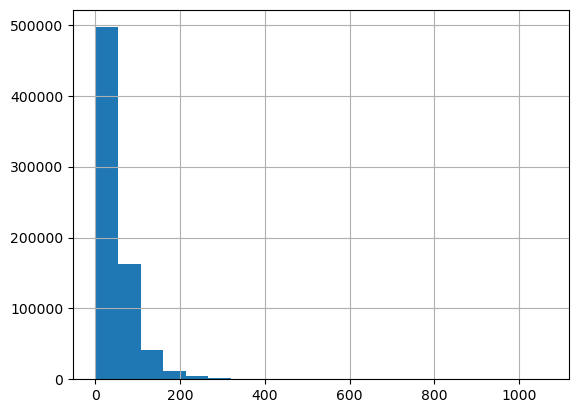

In [ ]:
df_train_reviews['word_count'].hist(bins = 20)
plt.show()

It seems clear that almost every review has under 200 words. Most reviews actually have less than 75/100 words.

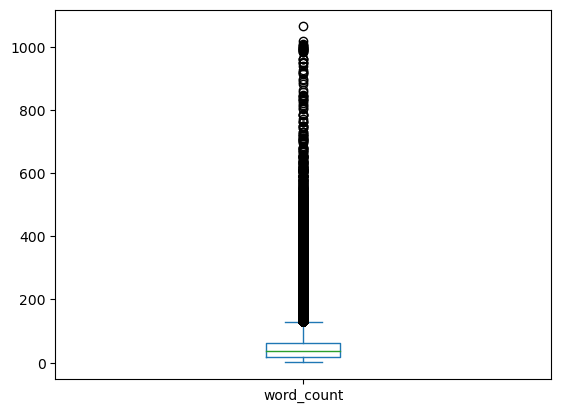

In [ ]:
df_train_reviews['word_count'].plot.box()
plt.show()

As we suspected from the boxplot, most reviews have under around 75 words. The skewed distribution comes from the existence of some outliers.

We just want to see how many revies have more than 512 words because of our models.

In [ ]:
df_train_reviews[df_train_reviews['word_count'] > 512]

,index,comments,word_count
4669,80,"While browsing, we found Antonio’s listed hous...",526
7631,162,"Excellent location. Gorgeous view, bright room...",666
7675,162,I will be the most objective and detailed rega...,515
8717,184,DO NOT STAY HERE. IT DOES NOT LOOK LIKE ...,628
8782,184,Are you looking for the perfect place to stay ...,990
...,...,...,...
712980,12324,Perfect location if you - like me - tend to ex...,537
713189,12333,This place has excellent access to public tran...,511
715293,12384,First and foremost I'd like to say that Monica...,539
716114,12395,De uma forma geral tivemos uma excelente estad...,508


There are only 236 reviews with more than 512 words.

Let's check the vocabulary of the reviews

In [ ]:
all_words = ' '.join(str(i) for i in df_train_reviews['comments'].values)

In [ ]:
all_words_list = all_words.split()

In [ ]:
freq = pd.Series(all_words_list).value_counts()
freq.sort_values(ascending=False)[0:10]

and     1098408
the     1028194
a        793019
to       653238
is       511900
in       497346
was      476359
of       347891
very     311495
The      285011
dtype: int64

In [ ]:
freq.sort_values(ascending=True)[0:400]

aspettative.<br/>A                1
accommodation!<br/>Recommended    1
Feb-                              1
Ugh                               1
acondicionado.<br/>En             1
                                 ..
glisser).                         1
(mettre                           1
blesser.                          1
viagem...nos                      1
מדי                               1
Length: 400, dtype: int64

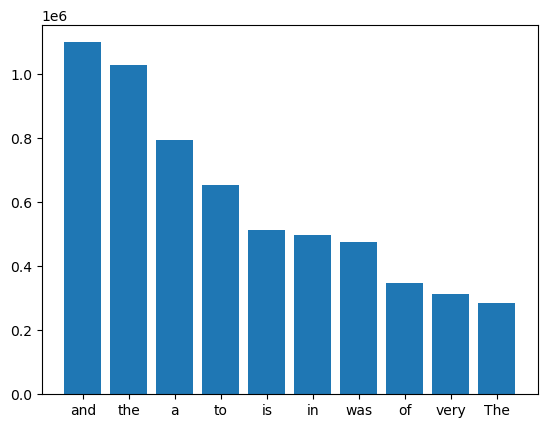

In [ ]:
plt.bar(freq.sort_values(ascending= False)[0:10].index, freq.sort_values(ascending=False)[0:10])
plt.show()

## 1.3. Joining the two datasets

In [ ]:
df_train = join_datasets(df_train_listings,df_train_reviews)

In [ ]:
df_train

,index,description,host_about,comments,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,[this is a very cozy and comfortable house to ...,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",[],1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",[],1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,[],0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,[Un très bel appartement avec une magnifique v...,0
...,...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,[Appartement très bien situé en plein coeur du...,0
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,"[Nice place, nice location, easy communication...",0
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,[Appartement bien situé et situé au centre vil...,0
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,[],1


In [ ]:
# set index column as the index
df_train.set_index('index', inplace = True)

## 1.4 Missing Values

In [ ]:
df_train.isnull().sum()

description    0
host_about     0
comments       0
unlisted       0
dtype: int64

# 2. Data Preprocessing

## 2.1. Train, validation and test split

Because the dataset is large enough, it seems safe to do a train, validation and test split. We'll use the train and validation to do the whole training of a model, but then the test part to acess the quality of the model in unseen data. In the end we will use the imported unlabeled set to do the final predictions.

As we have around 12000 rows, we'll do a 80/10/10 split (more or less).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('unlisted',axis=1), df_train.loc[:,'unlisted'], test_size=0.20, stratify = df_train.loc[:,'unlisted'], random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, stratify = y_val, random_state=42)

In [ ]:
X_train.head()

,description,host_about,comments
index,,,
7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,[Great house in a great location. Close to Lis...
11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",[]
3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,[Great getaway in cascais. Gorgeous apartment ...
4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...","[The studio is very charming, comfortable, has..."
2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...","[I'm portuguese from Lisbon , living in Italy,..."


## 2.2. Starting with language detection

We have multiple languages in our dataset, specially on the review column. This means that before preprocessing we need to see what is the language for each text, because when, for example, removing stopwords, we need to give the language as input, so the model knows what stopwords there are. So, we will start by detecting the language of the description, host_about and the lists inside the comments column. After this we can do the preprocessing using the data we gathered from that language search.

But because there can be detections captured by certain non linguistical elements in the text, we will first see what are the predominant languages in the dataset. This will use a smaller sample because of run time, but will give us an idea on that the language detection model will be capturing. We will do it on all the training set but with the caviat of just using the first review on the list so this exploratory step does not take too long. Afterwards, though, of course, we will detect every language of every piece of test, so we can safely remove stopwords.

### 2.2.1. Description column

In [ ]:
langs=detect_language(X_train['description']) # 2 minutes

In [ ]:
# add language description language as a column in the training set
X_train['description_lang'] = langs

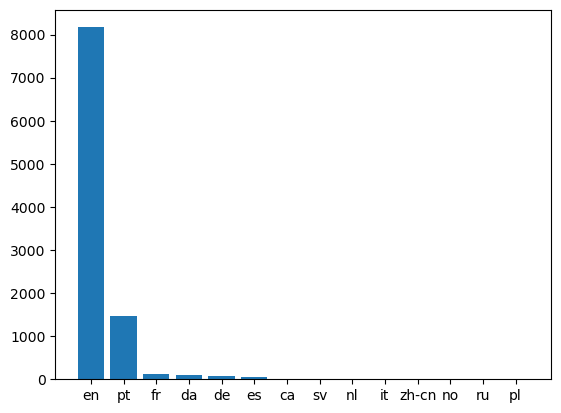

In [ ]:
plt.bar(X_train['description_lang'].value_counts().index, X_train['description_lang'].value_counts())
plt.show()

It is evident that most of the descriptions are in english, while also having some portuguese descriptions. The languages seem to make sense, so we will keep this column as the final detection for description language.

### 2.2.2. Host_about column

In [ ]:
langs=detect_language(X_train['host_about']) # 2 minutes

In [ ]:
# add language description language as a column in the training set
X_train['host_lang'] = langs

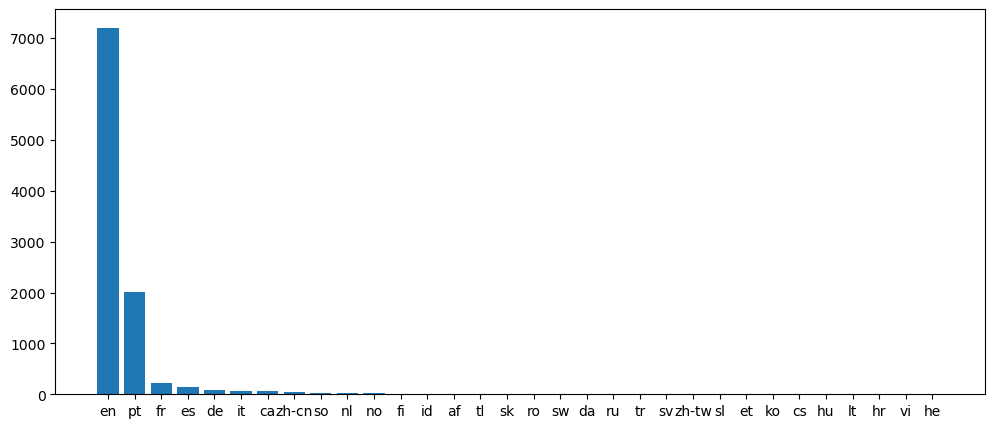

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(X_train['host_lang'].value_counts().index, X_train['host_lang'].value_counts())
plt.show()

The country codes also make sense for the most part. We will just have to be careful with the support of the stopwords and other models with certain languages. If something happens so it hasn't support for a certain language or the language itself does not make sense and is seemingly a detection error, we will revert the stopwords to one of the more popular languages in the dataset.

### 2.2.3. Comments column

As we said, for this step we will just use the first review's language, because there are hundreds of thousands of reviews. Note that this is only for exploration purposes, later we will detect the language of every comment.

In [ ]:
comment_langdetect = X_train['comments'].apply(lambda x: x[0] if len(x) > 0 else "")

In [ ]:
comment_langdetect

index
7713     Great house in a great location. Close to Lisb...
11334                                                     
3537     Great getaway in cascais. Gorgeous apartment a...
4062     The studio is very charming, comfortable, has ...
2743     I'm portuguese from Lisbon , living in Italy, ...
                               ...                        
8456     I couldn't wait to make an review and share my...
1692     Jose Carlos's place is great, as hi is new on ...
8386     Blue House were very professional and welcomin...
1501     Really am amazing place. I know this city very...
1737     The location of the house is very good, locate...
Name: comments, Length: 9996, dtype: object

In [ ]:
langs=detect_language(comment_langdetect)

In [ ]:
# add language description language as a column in the training set

comment_langdetect = pd.DataFrame(comment_langdetect)

comment_langdetect['comment_lang'] = langs

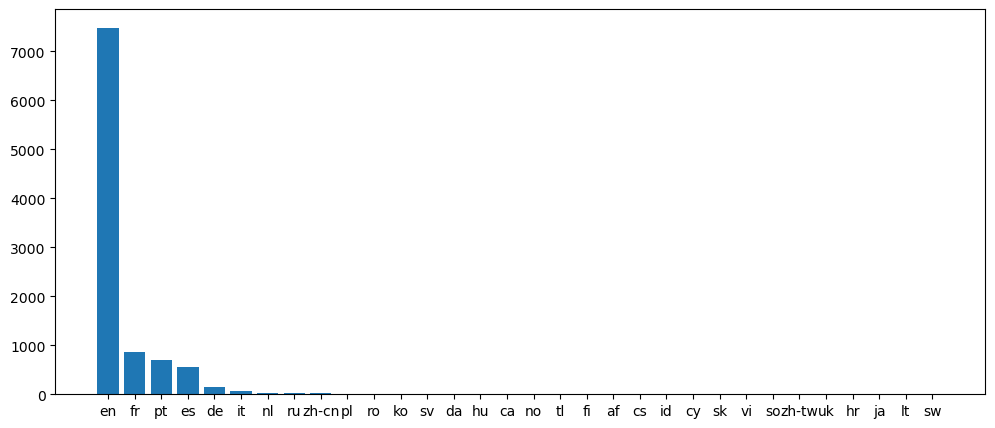

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(comment_langdetect['comment_lang'].value_counts().index, comment_langdetect['comment_lang'].value_counts())
plt.show()

### 2.2.4. Detecting all languages from all training set reviews

This will get a list with the language of each review in the list of reviews. That way makes the job of later referencing a language to each review easier, as theyll have the same index. This really takes a while to run, so we will save it as a csv and import it afterwards, so we do not have to run it every time we start the notebook.

In [ ]:
langs=detect_reviews_language(X_train['comments'])

In [ ]:
X_train['rev_lang'] = langs

Doing a checkpoint dataset with detected languages so we avoid processing times all the time we have to open the notebook - these steps are not supposed to be run if running the whole notebook at once.

In [ ]:
# # Checkpoint to decrease run times.
# X_train.to_csv("X_train.csv")

In [ ]:
# # For colab
# X_train = pd.read_csv("/content/drive/MyDrive/Project/X_train.csv")

# # For local
# X_train = pd.read_csv("X_train.csv")

# X_train['comments'] = [eval(X_train.comments[i]) for i in range(len(X_train))]
# X_train['rev_lang'] = [eval(X_train.rev_lang[i]) for i in range(len(X_train))]

In [ ]:
X_train['rev_lang'][0][0]

'en'

## 2.3. Text Cleaning

In [ ]:
X_train.head()

,index,description,host_about,comments,description_lang,host_lang,rev_lang
0,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,[Great house in a great location. Close to Lis...,en,en,"[en, en, fr, en, en, cs, en, en, en, en, en, e..."
1,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",[],en,en,[]
2,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,[Great getaway in cascais. Gorgeous apartment ...,en,en,"[en, en, en, en, es, en, en, fr, en, en, en, e..."
3,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...","[The studio is very charming, comfortable, has...",en,en,"[en, en, fr, en, it, pt, en, en, en, en, en, d..."
4,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...","[I'm portuguese from Lisbon , living in Italy,...",en,en,"[en, en, en, en, en, en, en, en, en, en, en, e..."


Let's check the most used languages to use them in the lemmatizer inside the cleaning function.

In [ ]:
X_train['description_lang'].value_counts()

en       8163
pt       1467
fr        122
da        102
de         74
es         42
sv          6
ca          5
zh-cn       4
no          3
nl          3
it          3
ru          1
pl          1
Name: description_lang, dtype: int64

We will use these languages only and revert to english if one is not like this, because we have to limit the amount and this is already a big amount of different languages.

We defined functions to clean the dataset. This includes: lowercasing, remove HTML tags, remove numerical and ponctuation data, remove stopwords, stem/lemmatize, remove emojis and remove rare words (the last two are extra-class).

In [ ]:
# testing = clean(X_train['description'][:3], X_train['description_lang'][:3], lemmatize= True, stemmer = False)

We defined a function to use the clean for all our columns, including reviews, which is a little different. We chose lemmatizing because it helps in further word embeddings.

The removal of rare words needs to be done after cleaning the dataset, because we want to remove useless words for our model. So, we do it now.

In [ ]:
clean_X_train = clean_dataframe(X_train) # Takes around 3.5 hours

100%|██████████| 9996/9996 [3:16:03<00:00,  1.18s/it]  


In [ ]:
# # Creating a checkpoint to decrease run times
# clean_X_train.to_csv("clean_X_train.csv")

In [ ]:
final_X_train = remove_rarest_from_df(clean_X_train)

100%|██████████| 9996/9996 [00:49<00:00, 201.33it/s]


In [ ]:
# # Creating a checkpoint to decrease run times~
# final_X_train.to_csv("final_X_train.csv")

# 3. Feature Engineering

## 3.1. Get the dataset ready for word embedding

In [ ]:
X_train = final_X_train[:] # if running all the notebook, this is the one

# X_train = pd.read_csv('/content/drive/MyDrive/Project/final_X_train.csv') # for colab checkpoint import
# X_train = pd.read_csv('final_X_train.csv') # for local checkpoint import

# Treat nans as empty strings
X_train.fillna('', inplace=True)

try:
  X_train['comments'] = [eval(X_train.comments[i]) for i in range(len(X_train))]
  X_train['host_about'] = [str(X_train.host_about[i]) for i in range(len(X_train))]
  X_train['rev_lang'] = [eval(X_train.rev_lang[i]) for i in range(len(X_train))]
except:
  pass

X_train['comments_joined'] = [' '.join(line) for line in X_train['comments']]

# Treat nans as empty strings again, because previously comments had lists and so would not detect nans with this, now it would
X_train.fillna('', inplace=True)

for c in ['description' , 'host_about' , 'comments_joined']:
  X_train[c] = X_train[c].astype(str)

X_train = X_train.set_index('index').loc[:,['description','host_about', 'comments_joined']]

X_train.rename(columns={'comments_joined':'comments'}, inplace=True)

In [ ]:
X_train

,description,host_about,comments
index,,,
7713,exclusive villa locate quiet pinewood area com...,couple big family love travel x d nice welcome...,great house great location close lisbon sintra...
11334,luna house b b part luna house hub locate clos...,luna house b b part luna house hub locate clos...,
3537,newly refurbish apartment swimming pool stunni...,world citizen look forward meet new people dis...,great getaway cascais gorgeous apartment excel...
4062,nice studio two people one bathroom compact ki...,hello antonio want welcome lisbon,studio charming comfortable everything need st...
2743,whether shorter long stay want offer solution ...,name alexandre live lisbon love travel world c...,portuguese lisbon live italy travel often back...
...,...,...,...
8456,small cozy historic apartment completely renov...,couple bear lisbon love live beautiful city lo...,wait make review share experience lovely coupl...
1692,fantastic double room quiet apartment lapa hou...,x d young enthusiastic music lover opportunity...,jose carlos place great hi new airbnb could fe...
8386,bedroom live dining room kitchen bathroom cais...,upon time one house make feel home house call ...,blue house professional welcoming ask flight d...


We want to divide each string into at most around 510 words, because the model can not accept strings that are too big. From what we have seen, the minimum of maxes a embedder accepts is 512, so we will divide everything into substrings of 510 words, so we can work with every word embedding.

Transforming the strings into lists of strings with maximum of 510 words:

In [ ]:
# Takes 4 minutes to run
X_train['description_div'] = tqdm(X_train.description.apply(divide_string))
X_train['host_about_div'] = tqdm(X_train.host_about.apply(divide_string))
X_train['comments_div'] = tqdm(X_train.comments.apply(divide_string))

100%|██████████| 9996/9996 [00:00<00:00, 2382580.14it/s]


So, this is the data we will use for word embeddings. As we can see below, it contains lists of strings with less than 510 words each, for every feature.

In [ ]:
print("first string:", X_train.iloc[0,2][0], "\n")
print("second string:", X_train.iloc[0,2][1])

first string: great house great location close lisbon sintra beach surf great walk super time ana nuno really great amazing house everything need much perfect location clean house ana nuno know hospitality one well rent accommodation ever magnifique maison lumineux meubler go propreté impeccable merveilleux jardin bel gand piscine discrètement intégrer paysager endroit paisible près plusieurs endroit magnifique plage site historique nécessiter voiture propriétaire plus gentil stay ana nuno perfect ton room four couple garden pool amazing room spacious enough we instantly feel calm arrive house greet kindly ana nuno immediately make we feel welcome home location perfect within minute drive two beach twenty minute drive sintra could strongly recommend villa amazing time stay absolutely wonderful week long stay lovely home near colare extend family seven age plenty room hang inside outside pleasure spend time together well equip comfortable stylish home outside space perfect nice gardens 

In [ ]:
# # Importing checkpoint to reduce run times
# X_train = pd.read_csv('X_train_4_embedding.csv') # local
# X_train = pd.read_csv('/content/drive/MyDrive/Project/X_train_4_embedding.csv') # Colab

# X_train.fillna('', inplace=True)
# X_train.set_index('index',inplace=True)

In [ ]:
X_train.head(3)

,description,host_about,comments,description_div,host_about_div,comments_div
index,,,,,,
7713,exclusive villa locate quiet pinewood area com...,couple big family love travel x d nice welcome...,great house great location close lisbon sintra...,['exclusive villa locate quiet pinewood area c...,['couple big family love travel x d nice welco...,['great house great location close lisbon sint...
11334,luna house b b part luna house hub locate clos...,luna house b b part luna house hub locate clos...,,['luna house b b part luna house hub locate cl...,['luna house b b part luna house hub locate cl...,[]
3537,newly refurbish apartment swimming pool stunni...,world citizen look forward meet new people dis...,great getaway cascais gorgeous apartment excel...,['newly refurbish apartment swimming pool stun...,['world citizen look forward meet new people d...,['great getaway cascais gorgeous apartment exc...


## 3.2. Word Embeddings

### 3.2.1. TF-IDF

In [ ]:
# Train tf-idf in the training set
word_tfidf_trained  = train_tfidf_embed(X_train, ['description','host_about','comments'])

In [ ]:
df_tfidf_embedding = tfidf_embed(X_train, ['description','host_about','comments'], word_tfidf_trained)

In [ ]:
df_tfidf_embedding

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column85768,column85769,column85770,column85771,column85772,column85773,column85774,column85775,column85776,column85777
index,,,,,,,,,,,,,,,,,,,,,
7713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
11334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.002721,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
8386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.011122,0.0,0.0,0.0,0.016811,0.0


### 3.2.2. GloVe Embeddings 6B 300 (Multilingual)

This is the GloVe embedding model we've seen in class. This one works for multiple languages.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
glove = vocab.GloVe(name='6B', dim=50) # decided for a smaller vector than the other approaches to vary a little.
print('Loaded {} words'.format(len(glove.itos)))

.vector_cache/glove.6B.zip: 862MB [02:42, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 35250.21it/s]


Loaded 400000 words


In [ ]:
df_glove_embedding = glove_embed(X_train , ['description','host_about','comments'])

In [ ]:
df_glove_embedding

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column140,column141,column142,column143,column144,column145,column146,column147,column148,column149
index,,,,,,,,,,,,,,,,,,,,,
7713,0.388902,0.439668,-0.000460,-0.099086,0.344110,-0.285059,-0.539240,-0.050507,-0.018264,-0.259630,...,-0.023308,0.023653,0.064055,0.099368,-0.002264,0.104462,-0.053161,-0.258318,0.105643,0.157698
11334,0.357415,0.349017,-0.064496,-0.089643,0.403790,-0.142834,-0.433263,-0.219717,0.066468,-0.100134,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3537,0.412844,0.336349,-0.045730,0.008688,0.095395,-0.380024,-0.423653,-0.193000,0.002325,-0.090258,...,-0.022409,-0.011539,0.077523,0.148728,0.019382,0.023320,-0.045169,-0.233012,0.164517,0.190432
4062,0.414640,0.341855,-0.041415,-0.083056,0.223474,-0.244855,-0.346303,-0.089418,0.007621,0.003932,...,0.012860,-0.000572,0.035836,0.088537,-0.009667,0.025834,-0.007137,-0.190136,0.195949,0.207999
2743,0.427366,0.244697,-0.008349,-0.178140,0.077444,-0.164031,-0.348868,0.036381,0.020512,-0.015459,...,0.045307,0.008704,0.085828,0.038695,-0.022345,0.038419,-0.022705,-0.140926,0.209875,0.168587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,0.471286,0.372010,-0.039566,-0.112072,0.064880,-0.331501,-0.482632,0.011924,0.028807,-0.087347,...,0.046488,-0.021008,0.099747,-0.029813,-0.082578,-0.039244,-0.030904,-0.197407,0.285648,0.153848
1692,0.305024,0.432382,-0.152891,-0.177430,0.471510,-0.207319,-0.399416,-0.022725,-0.145861,0.009407,...,0.024147,-0.017572,0.084628,-0.048992,-0.057792,-0.054197,-0.085309,-0.156432,0.271040,0.264284
8386,0.376325,0.399085,0.064888,-0.157057,0.203454,-0.264818,-0.541306,-0.040644,0.117760,-0.155621,...,0.080112,-0.045849,0.055618,0.013568,-0.027919,-0.068641,-0.027711,-0.116322,0.234845,0.232178


### 3.2.3. STSB-XLM-R-Multilingual

Import the pre-trained model first. It works for multiple languages.

In [ ]:
model_xlm = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual') # may take a while if it's the first time

Run said model to embed our data.

In [ ]:
df_xlm_embedding = embed_df(X_train, ['description_div','host_about_div','comments_div'], model_xlm)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/314 [00:00<?, ?it/s]

Batches:   0%|          | 0/1115 [00:00<?, ?it/s]

In [ ]:
df_xlm_embedding

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column758,column759,column760,column761,column762,column763,column764,column765,column766,column767
index,,,,,,,,,,,,,,,,,,,,,
7713,0.092718,0.292010,0.688604,0.375707,0.559067,-0.615857,-0.025207,-0.447041,0.416801,-0.276667,...,-0.174203,-0.507586,-0.202747,-0.211974,-0.059822,0.049201,-0.404148,0.108963,-0.154019,0.410771
11334,0.049890,-0.084942,1.355619,0.025930,0.268189,-0.438661,0.063208,-0.100294,0.165999,-0.378194,...,-0.364867,-0.536646,0.127681,-0.237241,-0.386427,-0.396079,-0.017884,0.378029,-0.112884,0.386140
3537,-0.045933,0.171114,1.183030,0.153309,0.438948,-0.489723,-0.365463,-0.083125,0.327483,-0.296445,...,-0.168778,-0.688806,-0.218425,-0.330269,-0.143643,-0.265441,0.014940,0.130018,-0.101259,0.071363
4062,0.065756,0.183783,0.978328,0.076925,0.463206,-0.494829,0.073601,-0.064694,0.074750,-0.124036,...,0.000562,-0.837640,-0.015282,-0.001585,0.017530,-0.414440,-0.058585,0.062175,-0.094638,0.291118
2743,0.026050,0.491328,1.172415,0.046046,0.525122,-0.624481,0.130987,-0.435060,0.236907,-0.093801,...,-0.159084,-0.686359,-0.092542,-0.155712,-0.315901,-0.097935,-0.092022,-0.025270,-0.230765,0.375059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,-0.166273,0.410638,0.710953,0.295370,0.223038,-0.734527,-0.271654,-0.170974,0.202319,-0.157697,...,-0.270119,-0.604146,-0.045402,-0.231710,-0.372486,-0.081651,-0.192386,-0.111367,0.128703,0.314646
1692,-0.361923,0.336841,1.049182,0.118798,0.979163,-0.762589,-0.266453,-0.581364,0.532546,-0.504719,...,-0.276676,-1.013904,-0.455149,-0.738984,-0.147143,-0.400876,-0.252436,0.274467,-0.213400,0.428956
8386,-0.470162,0.420791,0.828067,0.388097,0.609021,-1.037041,-0.117035,-0.180500,0.589203,-0.316869,...,-0.239162,-1.028156,-0.466990,-0.468730,0.060664,-0.362507,-0.002849,-0.067256,-0.259940,0.268120


### 3.2.4. Distiluse base multilingual-cased v2

In [ ]:
model_distiluse = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [ ]:
df_distiluse_embedding = embed_df(X_train, ['description_div','host_about_div','comments_div'], model_distiluse)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/314 [00:00<?, ?it/s]

Batches:   0%|          | 0/1115 [00:00<?, ?it/s]

In [ ]:
df_distiluse_embedding

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column502,column503,column504,column505,column506,column507,column508,column509,column510,column511
index,,,,,,,,,,,,,,,,,,,,,
7713,-0.000250,0.021483,-0.004614,-0.005041,0.061135,-0.019567,-0.011861,0.014085,0.035380,0.029097,...,0.004388,0.016938,-0.038707,0.013640,0.034832,0.033777,0.006207,-0.017099,-0.034200,0.002186
11334,-0.022306,0.034904,0.015360,-0.041501,0.022816,0.007818,0.011322,0.020281,0.010633,0.026117,...,0.002772,0.012678,-0.010292,0.010303,0.003438,-0.001838,-0.020363,-0.003634,0.008773,0.018613
3537,0.003193,0.017186,-0.010216,-0.044647,0.032757,-0.017354,-0.016788,0.000173,0.002003,0.013391,...,0.004026,0.037481,-0.024331,0.020135,0.022849,-0.030463,0.007349,-0.027004,0.007722,-0.017253
4062,0.001960,-0.000676,-0.026635,-0.028487,0.030726,-0.039813,-0.009508,-0.002794,-0.010787,0.013116,...,0.002926,0.002827,-0.011460,0.000757,0.006894,-0.022264,0.011445,-0.003750,-0.011266,-0.006009
2743,0.023829,0.025745,0.009203,-0.016457,0.014133,-0.014751,-0.026028,0.004003,0.029723,0.008864,...,0.012606,0.022965,-0.022629,0.015517,-0.009447,0.009875,-0.000457,-0.030209,-0.001243,-0.005543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,0.012824,0.032673,-0.019647,-0.014770,0.021027,-0.016802,-0.024775,0.005568,0.036751,0.022214,...,0.015503,0.017164,-0.029270,0.014181,-0.006227,-0.002270,-0.006225,-0.027856,0.007578,-0.002015
1692,0.015790,-0.017795,0.045001,-0.022673,0.059963,-0.021553,0.006181,0.031243,0.054755,0.034139,...,0.005118,0.012502,-0.049942,0.006327,0.041373,0.013425,0.029065,-0.037560,-0.021453,0.008313
8386,0.007310,-0.007601,0.002791,-0.008309,0.036821,-0.035876,-0.013554,0.006085,0.028536,0.019832,...,0.017305,-0.019239,-0.019322,-0.028704,0.038304,-0.013605,0.012897,-0.012554,-0.011356,0.015133


# 4. Models

In [ ]:
# # importing all embedded datasets first to save time when reruning the dataset
# df_glove_embedding = pd.read_csv("/content/drive/MyDrive/Project/df_glove_embedding.csv")
# df_xlm_embedding = pd.read_csv("/content/drive/MyDrive/Project/df_xlm_embedding.csv")
# df_distiluse_embedding = pd.read_csv("/content/drive/MyDrive/Project/df_distiluse_embedding.csv")

# df_glove_embedding.set_index('index',inplace=True)
# df_xlm_embedding.set_index('index',inplace=True)
# df_distiluse_embedding.set_index('index',inplace=True)

In [ ]:
df_xlm_embedding.head()

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column758,column759,column760,column761,column762,column763,column764,column765,column766,column767
index,,,,,,,,,,,,,,,,,,,,,
7713,0.092718,0.292010,0.688604,0.375707,0.559067,-0.615857,-0.025207,-0.447041,0.416801,-0.276667,...,-0.174203,-0.507586,-0.202747,-0.211974,-0.059822,0.049201,-0.404147,0.108963,-0.154019,0.410771
11334,0.049890,-0.084942,1.355619,0.025930,0.268189,-0.438661,0.063208,-0.100294,0.165999,-0.378194,...,-0.364867,-0.536646,0.127681,-0.237241,-0.386427,-0.396079,-0.017884,0.378029,-0.112884,0.386140
3537,-0.045933,0.171114,1.183029,0.153309,0.438948,-0.489723,-0.365463,-0.083125,0.327483,-0.296445,...,-0.168778,-0.688806,-0.218425,-0.330269,-0.143643,-0.265441,0.014940,0.130018,-0.101259,0.071363
4062,0.065756,0.183783,0.978328,0.076925,0.463207,-0.494829,0.073601,-0.064694,0.074750,-0.124036,...,0.000562,-0.837640,-0.015282,-0.001585,0.017530,-0.414440,-0.058585,0.062175,-0.094638,0.291118
2743,0.026050,0.491328,1.172415,0.046046,0.525122,-0.624481,0.130987,-0.435060,0.236907,-0.093801,...,-0.159084,-0.686359,-0.092542,-0.155712,-0.315901,-0.097935,-0.092022,-0.025270,-0.230765,0.375059


## 4.1. Building a pipeline with all the text processing steps

In [ ]:
nltk.download('punkt')
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:16<00:00, 24529.82it/s]


Loaded 400000 words


In [ ]:
X_val_preprocessed = text_preprocessor(X_val)
X_test_preprocessed = text_preprocessor(X_test)

100%|██████████| 1250/1250 [00:05<00:00, 217.82it/s]


In [ ]:
# # Import checkpoint to reduce run times (if not on colab remove the path until the name)
# X_val_preprocessed = pd.read_csv("/content/drive/MyDrive/Project/X_val_preprocessed.csv")
# X_test_preprocessed = pd.read_csv("/content/drive/MyDrive/Project/X_test_preprocessed.csv")

In [ ]:
X_val_distiluse = feature_eng(X_val_preprocessed,"distiluse")
X_val_xlm = feature_eng(X_val_preprocessed,"xlm")
X_val_glove = feature_eng(X_val_preprocessed,"glove")

X_test_distiluse = feature_eng(X_test_preprocessed,"distiluse")
X_test_xlm = feature_eng(X_test_preprocessed,"xlm")
X_test_glove = feature_eng(X_test_preprocessed,"glove")

In [ ]:
# # Importing all preprocessed and embedded validation and test sets (if not on colab remove path until the name)
# X_val_glove = pd.read_csv("/content/drive/MyDrive/Project/X_val_glove.csv")
# X_test_glove = pd.read_csv("/content/drive/MyDrive/Project/X_test_glove.csv")
# X_val_xlm = pd.read_csv("/content/drive/MyDrive/Project/X_val_xlm.csv")
# X_test_xlm = pd.read_csv("/content/drive/MyDrive/Project/X_test_xlm.csv")
# X_val_distiluse = pd.read_csv("/content/drive/MyDrive/Project/X_val_distiluse.csv")
# X_test_distiluse = pd.read_csv("/content/drive/MyDrive/Project/X_test_distiluse.csv")

# X_val_glove.set_index('index', inplace = True)
# X_test_glove.set_index('index', inplace = True)
# X_val_xlm.set_index('index', inplace = True)
# X_test_xlm.set_index('index', inplace = True)
# X_val_distiluse.set_index('index', inplace = True)
# X_test_distiluse.set_index('index', inplace = True)

## 4.2. K-Nearest Neighbours

### 4.2.1. Embedding Testing and Hyperparameter tuning

In [ ]:
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9, 12, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],  # Algorithm for nearest neighbors search
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

datasets = [
    {'name': 'Glove', 'features': df_glove_embedding, 'test': X_val_glove},
    {'name': 'Xlm', 'features': df_xlm_embedding, 'test': X_val_xlm},
    {'name': 'Distiluse', 'features': df_distiluse_embedding,'test': X_val_distiluse}
]

best_models = []

for df in datasets:
  df_name = df['name']
  X_train_cv = df['features']
  X_test_cv = df['test']

  knn = KNeighborsClassifier()

  random_search = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter=10,scoring="f1", cv=3, verbose=2)
  random_search.fit(X_train_cv, y_train)

  best_model = random_search.best_estimator_
  best_params = random_search.best_params_

  # Evaluating the best model on the training set
  y_train_pred = best_model.predict(X_train_cv)
  train_f1 = f1_score(y_train, y_train_pred)

  # Evaluating the best model on the val set
  y_test_pred = best_model.predict(X_test_cv)
  test_f1 = f1_score(y_val, y_test_pred)

  best_models.append({
        'dataset_name': df_name,
        'model': best_model,
        'train_f1_score': train_f1,
        'test_f1_score': test_f1,
        'params': best_params
    })


  print(f"{df_name}:")
  print(f"Training F1 score: {train_f1}")
  print(f"Test F1 score: {test_f1}")
  print(f"Best parameters: {best_params}")
  print("---------------------------------------")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   4.9s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   5.3s
[CV] END algorithm=brute, metric=manhattan, n_neighbors=7, weights=uniform; total time=   3.5s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=15, weights=distance; total time=   6.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=15, weights=distance; total time=   7.3s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=15, weights=distance; total time=   5.7s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=7, weights=uniform; total time=   3.9s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=7, weights=uniform; total time=   3.5s
[CV] END algorithm=kd_tree, metric=euclidean, n_neighbors=7, weights=uniform; total time=   2.9s
[CV] END algorithm=ball_tree, metric=manhattan, n_neighbors=15, we

### 4.2.2. Best Models

In [ ]:
best_models = pd.DataFrame(best_models)
best_models

,dataset_name,model,train_f1_score,test_f1_score,params
0,Glove,"KNeighborsClassifier(algorithm='brute', metric...",0.998195,0.786932,"{'weights': 'distance', 'n_neighbors': 12, 'me..."
1,Xlm,"KNeighborsClassifier(algorithm='ball_tree', me...",0.986691,0.288984,"{'weights': 'distance', 'n_neighbors': 2, 'met..."
2,Distiluse,"KNeighborsClassifier(algorithm='brute', metric...",0.563601,0.242958,"{'weights': 'uniform', 'n_neighbors': 3, 'metr..."


In [ ]:
best_model = pd.DataFrame([best_models["params"][0]])
best_model

,weights,n_neighbors,metric,algorithm
0,distance,12,manhattan,brute


### 4.2.3. Testing the best Model

In [ ]:
best_KNN_classifier = KNeighborsClassifier(n_neighbors=12, weights="distance", metric="manhattan", algorithm="brute")

In [ ]:
modelling(best_KNN_classifier, df_glove_embedding, y_train, train=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



In [ ]:
modelling(best_KNN_classifier, X_test_glove, y_test, train=False)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       904
           1       0.81      0.77      0.79       346

    accuracy                           0.89      1250
   macro avg       0.86      0.85      0.86      1250
weighted avg       0.89      0.89      0.89      1250



## 4.3. Logistic Regression

In [ ]:
model_lr_glove = LogisticRegression(max_iter=1000)

model_lr_xlm = LogisticRegression(max_iter=1000)

model_lr_distiluse = LogisticRegression(max_iter=1000)

### 4.3.1. Glove

In [ ]:
modelling(model_lr_glove , df_glove_embedding , y_train , True)

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7226
           1       0.76      0.84      0.79      2770

    accuracy                           0.88      9996
   macro avg       0.85      0.87      0.85      9996
weighted avg       0.89      0.88      0.88      9996



In [ ]:
modelling(model_lr_glove , X_val_glove , y_val , False)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       903
           1       0.68      0.80      0.74       347

    accuracy                           0.84      1250
   macro avg       0.80      0.83      0.81      1250
weighted avg       0.85      0.84      0.85      1250



### 4.3.2. XLM

In [ ]:
modelling(model_lr_xlm , df_xlm_embedding , y_train , True)

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      7226
           1       0.65      0.04      0.07      2770

    accuracy                           0.73      9996
   macro avg       0.69      0.51      0.45      9996
weighted avg       0.71      0.73      0.63      9996



In [ ]:
modelling(model_lr_xlm , X_val_xlm , y_val , False)

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       903
           1       0.31      0.02      0.04       347

    accuracy                           0.71      1250
   macro avg       0.52      0.50      0.44      1250
weighted avg       0.61      0.71      0.61      1250



### 4.3.3. Distiluse

In [ ]:
modelling(model_lr_distiluse , df_distiluse_embedding , y_train , True)

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      7226
           1       0.00      0.00      0.00      2770

    accuracy                           0.72      9996
   macro avg       0.36      0.50      0.42      9996
weighted avg       0.52      0.72      0.61      9996



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
modelling(model_lr_distiluse , X_val_distiluse, y_val , False)

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       903
           1       0.00      0.00      0.00       347

    accuracy                           0.72      1250
   macro avg       0.36      0.50      0.42      1250
weighted avg       0.52      0.72      0.61      1250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The best one was glove, so we will choose that embedding for this particular model.

### 4.3.4. Hyperparameter tuning

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0, scale=4),
    'solver': ['liblinear', 'saga']
}
logreg = LogisticRegression(max_iter=1000)
# Perform randomized search
random_search = RandomizedSearchCV(logreg, param_distributions=param_grid, n_iter=30,
                                   scoring='f1', random_state=42, verbose=1)
random_search.fit(df_glove_embedding, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters:  {'C': 0.4881529393791153, 'penalty': 'l1', 'solver': 'saga'}
Best Score:  0.7897703454689926


#### 4.3.5. Testing the final model

In [ ]:
best_LR_classifier = LogisticRegression(max_iter=1000, C= 0.4881529393791153, penalty = 'l1', solver = 'saga')

In [ ]:
modelling(best_LR_classifier, X_test_glove, y_test, train=False)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       904
           1       0.75      0.81      0.78       346

    accuracy                           0.87      1250
   macro avg       0.84      0.85      0.85      1250
weighted avg       0.88      0.87      0.88      1250



## 4.4. Multi-Layer Perceptron

In [ ]:
mlp_glove = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000)

mlp_xlm = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000)

mlp_distiluse = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=1000)

### 4.4.1. Glove

In [ ]:
modelling(mlp_glove , df_glove_embedding , y_train , True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       0.99      0.99      0.99      2770

    accuracy                           0.99      9996
   macro avg       0.99      0.99      0.99      9996
weighted avg       0.99      0.99      0.99      9996



In [ ]:
modelling(mlp_glove , X_val_glove , y_val , False)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       903
           1       0.72      0.72      0.72       347

    accuracy                           0.85      1250
   macro avg       0.81      0.81      0.81      1250
weighted avg       0.85      0.85      0.85      1250



### 4.4.2. XLM

In [ ]:
modelling(mlp_xlm , df_xlm_embedding , y_train , True)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      7226
           1       0.97      0.78      0.86      2770

    accuracy                           0.93      9996
   macro avg       0.94      0.88      0.91      9996
weighted avg       0.93      0.93      0.93      9996



In [ ]:
modelling(mlp_xlm , X_val_xlm , y_val , False)

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       903
           1       0.28      0.22      0.25       347

    accuracy                           0.63      1250
   macro avg       0.50      0.50      0.50      1250
weighted avg       0.60      0.63      0.61      1250



### 4.4.3. Distiluse

In [ ]:
modelling(mlp_distiluse , df_distiluse_embedding, y_train , True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7226
           1       0.97      0.96      0.97      2770

    accuracy                           0.98      9996
   macro avg       0.98      0.98      0.98      9996
weighted avg       0.98      0.98      0.98      9996



In [ ]:
modelling(mlp_distiluse , X_val_distiluse , y_val , False)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       903
           1       0.29      0.29      0.29       347

    accuracy                           0.61      1250
   macro avg       0.51      0.51      0.51      1250
weighted avg       0.61      0.61      0.61      1250



### 4.4.4. Hyperparameter tuning

In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh']
}
#Perform randomized search
mlp = MLPClassifier()
random_search_mlp = RandomizedSearchCV(mlp, param_distributions=param_grid_mlp, n_iter=10,
                                   scoring='f1', cv=3, random_state=42, verbose=2)
random_search_mlp.fit(df_glove_embedding, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=  16.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   8.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=  23.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=  27.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=  26.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=sgd; total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=sgd; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=sgd; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=  17.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=  17.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=  17.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   9.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   7.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=  10.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=  25.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=  25.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1, solver=sgd; total time=  14.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1, solver=sgd; total time=  18.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.1, solver=sgd; total time=   8.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.1, solver=sgd; total time=  16.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.1, solver=sgd; total time=  16.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 100), learning_rate_init=0.1, solver=sgd; total time=  11.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=  17.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=  17.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=sgd; total time=  32.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=sgd; total time=  31.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=sgd; total time=  31.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=MLPClassifier(),
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (100, 100)],
                                        'learning_rate_init': [0.001, 0.01,
                                                               0.1],
                                        'solver': ['sgd', 'adam']},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
#Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", random_search_mlp.best_params_)
print("Best Score: ", random_search_mlp.best_score_)

Best Hyperparameters:  {'solver': 'sgd', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'relu'}
Best Score:  0.7888645959473205


### 4.4.5. Testing best model

In [ ]:
best_MLP_classifier = MLPClassifier(hidden_layer_sizes=(50, 50, 50), alpha=0.0001, solver="sgd", learning_rate_init=0.001, activation="relu")

In [ ]:
modelling(best_MLP_classifier, df_glove_embedding, y_train, train=True)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7226
           1       0.77      0.83      0.80      2770

    accuracy                           0.88      9996
   macro avg       0.85      0.87      0.86      9996
weighted avg       0.89      0.88      0.89      9996



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
modelling(best_MLP_classifier, X_test_glove, y_test, train=False)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       904
           1       0.76      0.81      0.78       346

    accuracy                           0.87      1250
   macro avg       0.84      0.85      0.85      1250
weighted avg       0.88      0.87      0.88      1250




## 4.5. Best model choice

Surprisingly, our best models were all using glove embeddings. Let's analyse the results. The best models were the ones in the next cell. Every one of them performed better with glove embedding.

In [ ]:
best_KNN_classifier = KNeighborsClassifier(n_neighbors=12, weights="distance", metric="manhattan", algorithm="brute")

best_LR_classifier = LogisticRegression(max_iter=1000, C= 0.4881529393791153, penalty = 'l1', solver = 'saga')

best_MLP_classifier = MLPClassifier(hidden_layer_sizes=(50, 50, 50), alpha=0.0001, solver="sgd", learning_rate_init=0.001, activation="relu")

Let's repeat the testing with these models to compare them.

### 4.5.1. Training scores

In [ ]:
modelling(best_KNN_classifier, df_glove_embedding, y_train, train=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



In [ ]:
modelling(best_LR_classifier, df_glove_embedding, y_train, train=True)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7226
           1       0.75      0.84      0.79      2770

    accuracy                           0.88      9996
   macro avg       0.84      0.87      0.85      9996
weighted avg       0.88      0.88      0.88      9996



In [ ]:
modelling(best_MLP_classifier, df_glove_embedding, y_train, train=True)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      7226
           1       0.76      0.83      0.79      2770

    accuracy                           0.88      9996
   macro avg       0.84      0.86      0.85      9996
weighted avg       0.88      0.88      0.88      9996



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


We can see that the training scores for KNN are perfect. This will mean it will be the model that overfits the most, as the test scores will not be that high. It is better than all the others on precision, recall, f1-score and accuracy, having 1 in all of them. Regarding the other two, they are pretty similar, as they actually get identical results in the weighted average training scores, 0.88 for all scores.

### 4.5.2. Test Scores - includes our final model's scores

In [ ]:
modelling(best_KNN_classifier, X_test_glove, y_test, train=False)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       904
           1       0.81      0.77      0.79       346

    accuracy                           0.89      1250
   macro avg       0.86      0.85      0.86      1250
weighted avg       0.89      0.89      0.89      1250



In [ ]:
modelling(best_LR_classifier, X_test_glove, y_test, train=False)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       904
           1       0.75      0.81      0.78       346

    accuracy                           0.87      1250
   macro avg       0.84      0.85      0.85      1250
weighted avg       0.88      0.87      0.88      1250



In [ ]:
modelling(best_MLP_classifier, X_test_glove, y_test, train=False)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       904
           1       0.75      0.79      0.77       346

    accuracy                           0.87      1250
   macro avg       0.83      0.85      0.84      1250
weighted avg       0.87      0.87      0.87      1250



In spite of having the most overfitting of all, kNN actually seems to be the best model, as its test metrics surpass every metric from the other two models. It has 0.89 for precision, recall, accuracy and f1-score. We take the f1 score as being the most important, because our dataset is imbalanced, therefore this metric is the most trustable. MLP proved it was the worst, in spite of being the most complex of the three, suprisingly.

# 5. Prediction on unlabeled set (ready to run by itself)

Having chosen the embedding and the best model for it, it is time to predict on the unlabeled set. Because this step is the final model's predictions, we first have to train it using the full training dataset. So, we will produce all the necessary steps for prediction here. We need to get the training, preprocess it as we want, embed it and only then feed it onto the model. This section should be able to be run on its own.

#### 5.1. Importing the data

In [ ]:
# # In colab
# from google.colab import drive
# drive.mount('/content/drive')

# df_train_listings = pd.read_excel("/content/drive/MyDrive/Project/train.xlsx")
# df_train_reviews = pd.read_excel("/content/drive/MyDrive/Project/train_reviews.xlsx")

# df_test_listings = pd.read_excel("/content/drive/MyDrive/Project/test.xlsx")
# df_test_reviews = pd.read_excel("/content/drive/MyDrive/Project/test_reviews.xlsx")

In [ ]:
# In local storage
df_train_listings = pd.read_excel("train.xlsx")
df_train_reviews = pd.read_excel("train_reviews.xlsx")

df_test_listings = pd.read_excel("test.xlsx")
df_test_reviews = pd.read_excel("test_reviews.xlsx")

#### 5.2. Prepare data for processing by joining the two sets and detecting languages

In [ ]:
df_train = join_datasets(df_train_listings,df_train_reviews)
df_train.set_index('index', inplace = True)
df_test = join_test_datasets(df_test_listings,df_test_reviews)
df_test.set_index('index', inplace = True)

In [ ]:
df_train.head(2)

,description,host_about,comments,unlisted
index,,,,
1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,[this is a very cozy and comfortable house to ...,0
2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",[],1


In [ ]:
df_test.head(2)

,description,host_about,comments
index,,,
1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",[Thank you very much Antonio ! All has been pe...
2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"[This is a beautiful, bright apartment in a mo..."


In [ ]:
X = df_train.drop('unlisted', axis = 1)
y = df_train.loc[:,'unlisted']

X_test = df_test[:]

In [ ]:
clean_X = text_preprocessor(X)

In [ ]:
clean_X_test = text_preprocessor(X_test)

100%|██████████| 1389/1389 [00:08<00:00, 161.05it/s]


#### 5.3. Word Embedding

In [ ]:
nltk.download('punkt')
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|█████████▉| 399999/400000 [00:19<00:00, 20158.51it/s]


Loaded 400000 words


In [ ]:
final_X = feature_eng(clean_X, 'glove')

In [ ]:
final_X_test = feature_eng(clean_X_test, 'glove')

100%|██████████| 1389/1389 [00:00<00:00, 696376.79it/s]


In [ ]:
final_X

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column140,column141,column142,column143,column144,column145,column146,column147,column148,column149
index,,,,,,,,,,,,,,,,,,,,,
1,0.197940,0.465438,0.089530,-0.054976,0.286538,-0.279063,-0.438113,-0.090351,-0.013351,-0.046044,...,0.046633,-0.026322,0.048018,0.124953,0.028204,0.039201,-0.039162,-0.196842,0.189386,0.257863
2,0.041931,0.002277,-0.209455,0.158227,-0.100701,-0.868411,0.097127,0.007538,-0.048941,0.380512,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.401989,0.326411,-0.299297,-0.115907,0.182157,-0.517606,-0.334090,0.059039,-0.154405,0.013992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.099031,0.019642,-0.023990,0.326614,-0.121172,-0.321921,-0.069821,-0.140733,-0.080716,0.287024,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.183049,0.222132,-0.325787,-0.014039,-0.272399,-0.343609,0.092248,-0.154599,-0.068293,0.096496,...,0.084568,-0.056137,0.084144,-0.002567,-0.025178,-0.037937,-0.002178,-0.180426,0.252720,0.183184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12492,0.310896,0.287980,0.071760,-0.180594,0.315610,-0.190549,-0.376061,-0.111654,-0.014489,0.013082,...,-0.011173,0.010612,0.049761,0.069065,-0.024666,0.031229,0.007913,-0.196132,0.189778,0.199929
12493,0.457742,0.505284,-0.080432,-0.108963,0.407062,-0.279407,-0.486805,-0.061878,-0.055206,-0.037706,...,0.012794,0.038071,0.053587,0.105499,-0.023952,0.027017,-0.021628,-0.139822,0.182551,0.153628
12494,0.113061,0.425282,-0.250236,-0.126731,0.392141,-0.176110,-0.381844,-0.326189,-0.094646,-0.020562,...,-0.009241,-0.000003,0.062160,0.127280,-0.024805,0.042818,-0.015337,-0.192843,0.183299,0.180142


In [ ]:
final_X_test

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column140,column141,column142,column143,column144,column145,column146,column147,column148,column149
index,,,,,,,,,,,,,,,,,,,,,
1,0.531589,0.202495,-0.209048,-0.092120,0.153744,-0.511825,-0.392080,-0.021192,-0.206884,0.023311,...,-0.013042,0.029749,0.025871,0.113603,0.006260,0.074732,-0.035479,-0.275835,0.161996,0.200590
2,0.465722,0.256153,0.033702,-0.025795,0.038058,-0.216112,-0.282097,-0.191867,0.234806,-0.073541,...,-0.023030,-0.026693,0.094189,0.122636,-0.038299,-0.069524,-0.026288,-0.146695,0.247023,0.166068
3,0.485387,0.400793,-0.061855,-0.279742,0.593800,-0.060671,-0.394121,-0.121324,-0.020757,-0.057670,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.449800,0.454170,0.020948,-0.180201,0.462219,-0.176544,-0.386829,0.012194,0.028547,-0.107912,...,0.058567,0.028536,0.057162,0.114199,-0.007030,0.074429,-0.016453,-0.328466,0.180937,0.126160
5,0.093894,0.029971,-0.084821,0.090785,-0.226771,-0.366577,0.156363,-0.021096,-0.049326,0.284169,...,0.186762,-0.073011,0.096235,-0.112747,-0.062570,-0.187430,-0.001172,-0.127336,0.300233,0.253664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,0.057529,-0.080907,0.012441,0.090069,-0.156687,-0.212116,0.116746,-0.103617,-0.076213,0.237339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1386,0.505052,0.270624,-0.148228,-0.060007,0.200417,-0.375240,-0.263487,-0.034803,-0.099939,0.146796,...,0.100454,-0.025962,0.084345,-0.018779,-0.029757,-0.055002,-0.026150,-0.146968,0.235315,0.247301
1387,0.325969,0.429797,-0.074941,-0.125753,0.332702,-0.176075,-0.409429,-0.093461,-0.035558,0.011721,...,0.108125,-0.041944,0.069338,-0.046135,-0.067097,-0.072718,-0.010257,-0.114387,0.268898,0.186136


In [ ]:
y

index
1        0
2        1
3        1
4        0
5        0
        ..
12492    0
12493    0
12494    0
12495    1
12496    1
Name: unlisted, Length: 12496, dtype: int64

#### 5.4. Model training and predictions

In [ ]:
final_model_KNN = KNeighborsClassifier(n_neighbors=12, weights="distance", metric="manhattan", algorithm="brute")

In [ ]:
final_model_KNN.fit(final_X,y)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=12,
                     weights='distance')

In [ ]:
predictions = final_model_KNN.predict(final_X_test)

In [ ]:
predictions_df = pd.Series(predictions, index = final_X_test.index)

In [ ]:
predictions_df

index
1       0
2       0
3       0
4       0
5       0
       ..
1385    1
1386    0
1387    0
1388    0
1389    1
Length: 1389, dtype: int64

In [ ]:
predictions_df.to_csv('Predictions_14.csv')